# BERT = Bidirectional Encoder Representations from Transformers
Es una herramienta usada en NLP que a diferencia de Word2Vec, BERT genera embedding bajo el contexto de la sentencia para las palabras que puedan tener distintos significados según lo que se quiera decir

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd

In [34]:
df = pd.read_csv("spam.csv")
df = df[['v1','v2']]
df.head(5)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [35]:
# Vemos que tenemos 4825 mails normales y 747 mails spam. Por lo tanto tenemos imbalance
# v1: Category y v2: Message
df.groupby('v1').describe()

v2                                                               
     count unique                                                top freq
v1                                                                       
ham   4825   4516                             Sorry, I'll call later   30
spam   747    653  Please call our customer service representativ...    4

In [36]:
# Vamos a usar downsampling para tener un dataset balanceado
df_spam = df[df['v1'] == 'spam']
df_ham = df[df['v1'] == 'ham']
df_hamdown = df_ham.sample(747)
df_balance = pd.concat([df_spam, df_hamdown])

print(df_balance.shape)
print(df_balance.sample(5))

(1494, 2)
        v1                                                 v2
1543  spam  Hello from Orange. For 1 month's free access t...
3396   ham                       Heehee that was so funny tho
5309   ham  Jolly good! By the way,  will give u tickets f...
2317   ham  Waqt se pehle or naseeb se zyada kisi ko kuch ...
4843  spam  YOU HAVE WON! As a valued Vodafone customer ou...


In [38]:
# Creamos una nueva columna que tiene 1 si el mensaje es spam y 0 en otro caso
df_balance['spam'] = df_balance['v1'].apply(lambda x: 1 if x == 'spam' else 0)
print(df_balance.sample(5))

        v1                                                 v2  spam
2144  spam  FreeMsg: Hey - I'm Buffy. 25 and love to satis...     1
3118   ham                           Stop knowing me so well!     0
1520  spam  URGENT! Your Mobile No was awarded a �2,000 Bo...     1
2264   ham  Ok . . now i am in bus. . If i come soon i wil...     0
1574   ham  My sis is catching e show in e afternoon so i'...     0


In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_balance['v2'], df_balance['spam'], stratify=df_balance['spam'])

In [40]:
# Importamos el modelo BERT desde hub
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [41]:
# Vamos a crear una función que dada una sentencia, devuelva un vector de tamaño 768
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

# La probamos
get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351707, -0.5132728 , -0.8884573 , ..., -0.74748874,
        -0.7531474 ,  0.91964495],
       [-0.87208354, -0.50543964, -0.9444667 , ..., -0.858475  ,
        -0.7174534 ,  0.88082975]], dtype=float32)>

In [44]:
# Creamos el modelo
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
l = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)
model = tf.keras.Model(inputs = [text_input], outputs = [l])

In [46]:
# Notemos que tenemos 768+1 parametros entrenables, los demás no lo son porque vienen del modelo BERT pre-entrenado
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [53]:
metricas = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = metricas)


In [54]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 201s 5s/step - loss: 0.6876 - accuracy: 0.5938 - precision: 0.6008 - recall: 0.5589
Epoch 2/10
35/35 [==============================] - 188s 5s/step - loss: 0.5536 - accuracy: 0.7955 - precision: 0.7919 - recall: 0.8018
Epoch 3/10
35/35 [==============================] - 184s 5s/step - loss: 0.4749 - accuracy: 0.8402 - precision: 0.8348 - recall: 0.8482
Epoch 4/10
35/35 [==============================] - 185s 5s/step - loss: 0.4319 - accuracy: 0.8589 - precision: 0.8306 - recall: 0.9018
Epoch 5/10
35/35 [==============================] - 184s 5s/step - loss: 0.3929 - accuracy: 0.8696 - precision: 0.8532 - recall: 0.8929
Epoch 6/10
35/35 [==============================] - 184s 5s/step - loss: 0.3617 - accuracy: 0.8813 - precision: 0.8650 - recall: 0.9036
Epoch 7/10
35/35 [==============================] - 187s 5s/step - loss: 0.3416 - accuracy: 0.8929 - precision: 0.8780 - recall: 0.9125
Epoch 8/10
35/35 [==============================

In [55]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 59s 5s/step - loss: 0.2716 - accuracy: 0.9118 - precision: 0.8889 - recall: 0.9412


[0.2715587913990021,
 0.9117646813392639,
 0.8888888955116272,
 0.9411764740943909]

In [56]:
import numpy as np
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,

Text(33.0, 0.5, 'Truth')

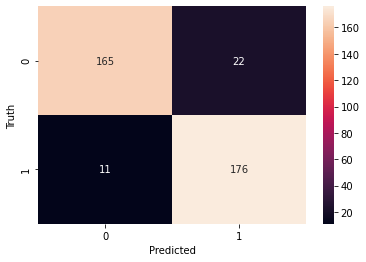

In [57]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_predicted)
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [58]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       187
           1       0.89      0.94      0.91       187

    accuracy                           0.91       374
   macro avg       0.91      0.91      0.91       374
weighted avg       0.91      0.91      0.91       374



In [59]:
# Probamos con algunos mails
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

array([[0.7690573 ],
       [0.8190883 ],
       [0.77017087],
       [0.20904022],
       [0.12733907]], dtype=float32)